In [1]:
name = "Renata Sarmet Smiderle Mendes"  # write YOUR NAME

honorPledge = "I affirm that I have not given or received any unauthorized " \
              "help on this assignment, and that this work is my own.\n"


print("\nName: ", name)
print("\nHonor pledge: ", honorPledge)



Name:  Renata Sarmet Smiderle Mendes

Honor pledge:  I affirm that I have not given or received any unauthorized help on this assignment, and that this work is my own.



# Preprocessing

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
(X_train_ori, y_train_ori), (X_test_ori, y_test_ori) = mnist.load_data()

print(X_train_ori.shape, y_train_ori.shape)
print(X_test_ori.shape, y_test_ori.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


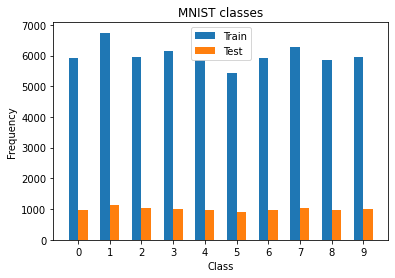

In [4]:
labels = ["%s"%i for i in range(10)]

unique, counts = np.unique(y_train_ori, return_counts=True)
uniquet, countst = np.unique(y_test_ori, return_counts=True)

fig, ax = plt.subplots()
rects1 = ax.bar(unique - 0.15, counts, 0.3, label='Train')
rects2 = ax.bar(unique + 0.15, countst, 0.3, label='Test')
ax.legend()
ax.set_xticks(unique)
ax.set_xticklabels(labels)

plt.title('MNIST classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

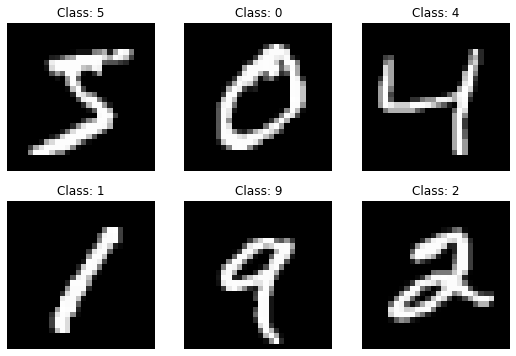

In [5]:
fig, ax = plt.subplots(2, 3, figsize = (9, 6))

for i in range(6):
    ax[i//3, i%3].imshow(X_train_ori[i], cmap='gray')
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title("Class: %d"%y_train_ori[i])
    
plt.show()

In [6]:
# Reduce the image size to its half 
X_train = np.array([image[::2, 1::2] for image in X_train_ori])
X_test  = np.array([image[::2, 1::2] for image in X_test_ori])

y_train = y_train_ori
y_test = y_test_ori

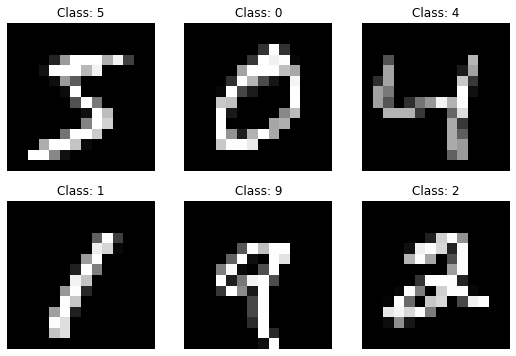

In [7]:
fig, ax = plt.subplots(2, 3, figsize = (9, 6))

for i in range(6):
    ax[i//3, i%3].imshow(X_train[i], cmap='gray')
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title("Class: %d"%y_train_ori[i])
    
plt.show()

In [8]:
X_train = (X_train/255.0).astype('float32').reshape((60000,14*14))
X_test = (X_test/255.0).astype('float32').reshape((10000,14*14))

print(X_train.dtype)
print(X_test.dtype)

print("\nShape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

print("\nMinimum value in X_train:", np.amin(X_train))
print("Maximum value in X_train:", np.amax(X_train))

print("\nMinimum value in X_test:", np.amin(X_test))
print("Maximum value in X_test:", np.amax(X_test))


float32
float32

Shape of X_train:  (60000, 196)
Shape of X_test:  (10000, 196)

Minimum value in X_train: 0.0
Maximum value in X_train: 1.0

Minimum value in X_test: 0.0
Maximum value in X_test: 1.0


# Separating Datasets

We will separate de training set into two parts in a stratified way: 70% train and 30% validation.

In [9]:
# Splitting the dataset in a stratified way
X_train_set, X_val, y_train_set, y_val = train_test_split(X_train, y_train, 
                                                           test_size=0.3,
                                                           stratify=y_train,
                                                           random_state=42)

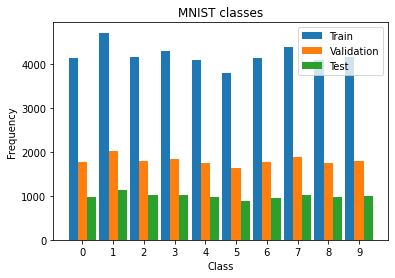

In [10]:
# Checking the classes distributions. We can see that it is indeed stratified.
labels = ["%s"%i for i in range(10)]

unique, counts = np.unique(y_train_set, return_counts=True)
uniquev, countsv = np.unique(y_val, return_counts=True)
uniquet, countst = np.unique(y_test, return_counts=True)

fig, ax = plt.subplots()
rects1 = ax.bar(unique - 0.3, counts, 0.3, label='Train')
rects2 = ax.bar(unique, countsv, 0.3, label='Validation')
rects3 = ax.bar(unique + 0.3, countst, 0.3, label='Test')
ax.legend()
ax.set_xticks(unique)
ax.set_xticklabels(labels)

plt.title('MNIST classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Training, evaluating and selecting models

We will use the X_train_set and y_train_set to train different models, varying the hyperparameters, and choose the best configuration for each one. For that, we will use grid search techniques and cross validation. The grid search considers all parameter combinations and the cross validation splits the data into k folds and use k-1 folds to train and 1 fold to test, so we don't need to split our data one more time.


In order to choose the best configuratoin, we will analyse the precision, the recall and the execution time. The precision is the the proportion of predicted Positives that is truly Positive (TP/(TP+FP)) and recall is the proportion of actual Positives that is correctly classified (TP/(TP+FN)).

After this step, we will have three selected models: a logistic regression model, a neural network model, and a SVM model.

In [11]:
def train_with_grid_search_cv(model, param_grid, X_train, y_train):
    # Grid search cv with 5 folds
    # We will analyse both precision and recall, 
    # but the precision will be use to choose and refit with the best params
    clf = GridSearchCV(estimator=model, 
                       param_grid=param_grid, 
                       scoring=['precision_macro', 'recall_macro'],
                       refit='precision_macro',
                       cv=5
                       #, verbose=3 # uncomment it if you want to check the score for each fold
                      )
    clf.fit(X_train, y_train)

    print(f"\nBest parameters set found according to precision ({clf.best_score_:.3f}): {clf.best_params_}.")
    print("\nGrid scores:")
    means_precision = clf.cv_results_['mean_test_precision_macro']
    means_recall = clf.cv_results_['mean_test_recall_macro']
    means_fit_time = clf.cv_results_['mean_fit_time']
    for mean_p, mean_r, mean_t, params in zip(means_precision, means_recall, means_fit_time, clf.cv_results_['params']):
        print(f"mean: precision ({mean_p:.3f}), recall ({mean_r:.3f}) and fit time ({mean_t:.3f}s) for {params}")
    print()
    
    return clf

## Logistic Regression

In [13]:
# Previous tests were made varying other parameters, 
# but after all, due to long execution time, 
# it was decided to keep this param_grid varying penalty and solver
param_grid = [{'penalty': ['l2', 'none'],
               'solver' : ['lbfgs', 'newton-cg', 'sag', 'saga'],
               'random_state': [42]
              }]

logistic = train_with_grid_search_cv(LogisticRegression(), 
                                          param_grid, 
                                          X_train_set, 
                                          y_train_set)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END penalty=l2, random_state=42, solver=lbfgs; precision_macro: (test=0.909) recall_macro: (test=0.909) total time=   2.9s
[CV 2/5] END penalty=l2, random_state=42, solver=lbfgs; precision_macro: (test=0.907) recall_macro: (test=0.906) total time=   2.4s
[CV 3/5] END penalty=l2, random_state=42, solver=lbfgs; precision_macro: (test=0.904) recall_macro: (test=0.903) total time=   2.5s
[CV 4/5] END penalty=l2, random_state=42, solver=lbfgs; precision_macro: (test=0.912) recall_macro: (test=0.913) total time=   2.5s
[CV 5/5] END penalty=l2, random_state=42, solver=lbfgs; precision_macro: (test=0.902) recall_macro: (test=0.901) total time=   2.5s
[CV 1/5] END penalty=l2, random_state=42, solver=newton-cg; precision_macro: (test=0.909) recall_macro: (test=0.909) total time=  26.6s
[CV 2/5] END penalty=l2, random_state=42, solver=newton-cg; precision_macro: (test=0.907) recall_macro: (test=0.906) total time=  16.0s
[CV 3/5]

We can see that there is not much change in the precision and recall, and there are some parameters that take much longer than the others (example solver newton-cg with no penalty, it took around 8 minutes). Considering all of that, the solver lbfgs with no penalty got almost the same result as the best one, but under than 3 seconds.

So, we will keep the params = {'penalty': 'none', 'solver': 'lbfgs'} for the Logistic Regression.

In [12]:
# Retraning Logistic Regression on the X_train_set with the best params 
clf_logistic = LogisticRegression(penalty= 'none', 
                                  solver= 'lbfgs',
                                  random_state= 42)
clf_logistic.fit(X_train_set, y_train_set)

LogisticRegression(penalty='none', random_state=42)

## Neural Network Model

In [17]:
# Previous tests were made varying other parameters, 
# but after all, due to long execution time, 
# it was decided to keep this param_grid varying hidden_layer_sizes and activation
param_grid = [{'hidden_layer_sizes': [(10,), (10,10), (100,), (100,100), (500,), (500,500)],
               'activation': ['identity', 'logistic', 'tanh', 'relu'],
               'random_state': [42]
              }]
mlp = train_with_grid_search_cv(MLPClassifier(), 
                                  param_grid, 
                                  X_train_set, 
                                  y_train_set)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END activation=identity, hidden_layer_sizes=(10,), random_state=42; precision_macro: (test=0.911) recall_macro: (test=0.911) total time=  11.1s
[CV 2/5] END activation=identity, hidden_layer_sizes=(10,), random_state=42; precision_macro: (test=0.910) recall_macro: (test=0.908) total time=   7.9s
[CV 3/5] END activation=identity, hidden_layer_sizes=(10,), random_state=42; precision_macro: (test=0.905) recall_macro: (test=0.905) total time=   7.6s
[CV 4/5] END activation=identity, hidden_layer_sizes=(10,), random_state=42; precision_macro: (test=0.912) recall_macro: (test=0.912) total time=   8.6s
[CV 5/5] END activation=identity, hidden_layer_sizes=(10,), random_state=42; precision_macro: (test=0.903) recall_macro: (test=0.902) total time=  11.0s
[CV 1/5] END activation=identity, hidden_layer_sizes=(10, 10), random_state=42; precision_macro: (test=0.911) recall_macro: (test=0.911) total time=  11.5s
[CV 2/5] END acti

[CV 4/5] END activation=logistic, hidden_layer_sizes=(500,), random_state=42; precision_macro: (test=0.974) recall_macro: (test=0.974) total time= 1.2min
[CV 5/5] END activation=logistic, hidden_layer_sizes=(500,), random_state=42; precision_macro: (test=0.974) recall_macro: (test=0.973) total time= 1.3min
[CV 1/5] END activation=logistic, hidden_layer_sizes=(500, 500), random_state=42; precision_macro: (test=0.974) recall_macro: (test=0.974) total time= 2.1min
[CV 2/5] END activation=logistic, hidden_layer_sizes=(500, 500), random_state=42; precision_macro: (test=0.974) recall_macro: (test=0.973) total time= 1.8min
[CV 3/5] END activation=logistic, hidden_layer_sizes=(500, 500), random_state=42; precision_macro: (test=0.969) recall_macro: (test=0.969) total time= 2.0min
[CV 4/5] END activation=logistic, hidden_layer_sizes=(500, 500), random_state=42; precision_macro: (test=0.974) recall_macro: (test=0.974) total time= 2.2min
[CV 5/5] END activation=logistic, hidden_layer_sizes=(500, 5

[CV 3/5] END activation=relu, hidden_layer_sizes=(100, 100), random_state=42; precision_macro: (test=0.966) recall_macro: (test=0.966) total time=  16.1s
[CV 4/5] END activation=relu, hidden_layer_sizes=(100, 100), random_state=42; precision_macro: (test=0.969) recall_macro: (test=0.969) total time=  14.9s
[CV 5/5] END activation=relu, hidden_layer_sizes=(100, 100), random_state=42; precision_macro: (test=0.966) recall_macro: (test=0.966) total time=  14.5s
[CV 1/5] END activation=relu, hidden_layer_sizes=(500,), random_state=42; precision_macro: (test=0.975) recall_macro: (test=0.975) total time=  33.9s
[CV 2/5] END activation=relu, hidden_layer_sizes=(500,), random_state=42; precision_macro: (test=0.976) recall_macro: (test=0.975) total time=  28.2s
[CV 3/5] END activation=relu, hidden_layer_sizes=(500,), random_state=42; precision_macro: (test=0.973) recall_macro: (test=0.973) total time=  30.6s
[CV 4/5] END activation=relu, hidden_layer_sizes=(500,), random_state=42; precision_macr

We can see that the activation 'identity' was the worst, no matter the hidden layers. The other three were very similar, and the 'tanh' and 'relu' were the best two. There were a few parameters that got 0.975 precision and 0.97 recall, but considering the execution time, the 'relu' with hidden_layer_sizes (500,) was the best one.

So, we will keep the params = {'activation': 'relu', 'hidden_layer_sizes': (500,)} for the Neural Network.

In [13]:
# Retraning MLPClassifier on the X_train_set with the best params
clf_neural_network = MLPClassifier(activation='relu',
                                  hidden_layer_sizes=(500,),
                                  random_state=42)
clf_neural_network.fit(X_train_set, y_train_set)

MLPClassifier(hidden_layer_sizes=(500,), random_state=42)

## Support Vector Machines Model

In [15]:
# Previous tests were made varying other parameters, 
# but after all, due to long execution time, 
# it was decided to keep this param_grid varying loss and multi_class
param_grid = [{'loss': ['hinge', 'squared_hinge'],
               'multi_class': ['ovr', 'crammer_singer'],
               'random_state': [42]
              }]

svc = train_with_grid_search_cv(LinearSVC(), 
                                  param_grid, 
                                  X_train_set, 
                                  y_train_set)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END loss=hinge, multi_class=ovr, random_state=42; precision_macro: (test=0.901) recall_macro: (test=0.901) total time=   2.4s
[CV 2/5] END loss=hinge, multi_class=ovr, random_state=42; precision_macro: (test=0.901) recall_macro: (test=0.901) total time=   2.1s
[CV 3/5] END loss=hinge, multi_class=ovr, random_state=42; precision_macro: (test=0.900) recall_macro: (test=0.900) total time=   2.0s
[CV 4/5] END loss=hinge, multi_class=ovr, random_state=42; precision_macro: (test=0.905) recall_macro: (test=0.905) total time=   2.0s
[CV 5/5] END loss=hinge, multi_class=ovr, random_state=42; precision_macro: (test=0.897) recall_macro: (test=0.896) total time=   2.0s
[CV 1/5] END loss=hinge, multi_class=crammer_singer, random_state=42; precision_macro: (test=0.911) recall_macro: (test=0.911) total time=  12.2s
[CV 2/5] END loss=hinge, multi_class=crammer_singer, random_state=42; precision_macro: (test=0.910) recall_macro: (test

We can see that the multi_class 'ovr' did a little worse than the 'crammer_singer' on both loss functions. Also, if 'crammer_singer' is chosen on the multi_class parameter, the option loss is ignored, that's why it got the same precision and recall regardless of the loss function and with execution time very close to each other.  

So, we will keep the params = {'multi_class': 'crammer_singer'} for the SVM.

In [14]:
# Retraning LinearSVC on the X_train_set with the best params
clf_svm = LinearSVC(multi_class='crammer_singer',
                   random_state=42)
clf_svm.fit(X_train_set, y_train_set)

LinearSVC(multi_class='crammer_singer', random_state=42)

# Choosing a Final Model

In this step, we will use the X_val and y_val to evaluate the three models selected in the previous step and select the best one.

As we used the precision to decide the best model in the previous step, we will keep doing it here. Although, to enrich the analysis, we will also check some other metrics.

The confusion matrix is used to evaluate the quality of the output of a classifier. According to the sklearn documentation, the diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

In addition to the confusion matrix, we will print a classification report, with information about precision, recall and f1-score, separated by class and overall.

In [55]:
def analyse_metrics(model_name, model, X_true, y_true, y_pred):

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title(f'{model_name} - Normalized Confusion Matrix')
    disp = plot_confusion_matrix(model, X_true, y_true, ax=ax, normalize='true')
    plt.show()

    # Print classification report
    print(classification_report(y_true, y_pred))

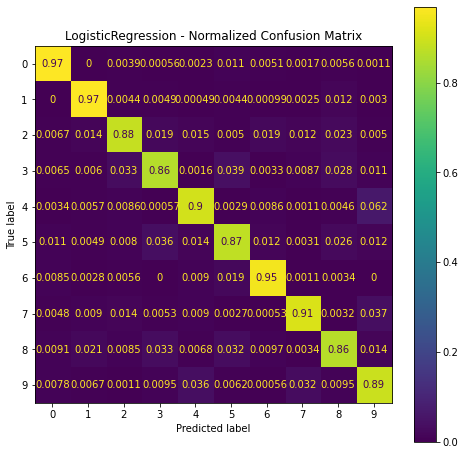

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1777
           1       0.94      0.97      0.95      2023
           2       0.91      0.88      0.89      1787
           3       0.89      0.86      0.88      1839
           4       0.91      0.90      0.90      1753
           5       0.87      0.87      0.87      1626
           6       0.94      0.95      0.95      1775
           7       0.94      0.91      0.92      1880
           8       0.88      0.86      0.87      1755
           9       0.86      0.89      0.87      1785

    accuracy                           0.91     18000
   macro avg       0.91      0.91      0.91     18000
weighted avg       0.91      0.91      0.91     18000



In [56]:
# Evaluating Logistic Regression
y_pred = clf_logistic.predict(X_val)

# Analyse metrics
analyse_metrics(model_name= 'LogisticRegression', 
                model=clf_logistic,
                X_true=X_val,
                y_true=y_val, 
                y_pred=y_pred)

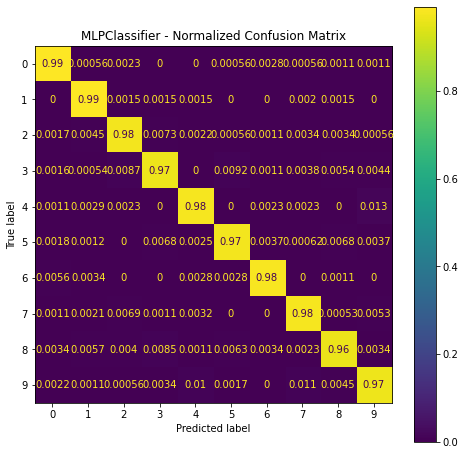

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1777
           1       0.98      0.99      0.99      2023
           2       0.97      0.98      0.97      1787
           3       0.97      0.97      0.97      1839
           4       0.98      0.98      0.98      1753
           5       0.98      0.97      0.97      1626
           6       0.99      0.98      0.99      1775
           7       0.98      0.98      0.98      1880
           8       0.98      0.96      0.97      1755
           9       0.97      0.97      0.97      1785

    accuracy                           0.98     18000
   macro avg       0.98      0.98      0.98     18000
weighted avg       0.98      0.98      0.98     18000



In [57]:
# Evaluating Neural Network
y_pred = clf_neural_network.predict(X_val)

# Analyse metrics
analyse_metrics(model_name= 'MLPClassifier', 
                model=clf_neural_network,
                X_true=X_val,
                y_true=y_val, 
                y_pred=y_pred)

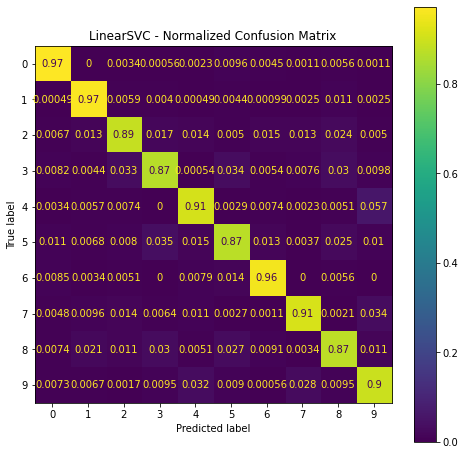

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1777
           1       0.94      0.97      0.95      2023
           2       0.91      0.89      0.90      1787
           3       0.90      0.87      0.88      1839
           4       0.91      0.91      0.91      1753
           5       0.88      0.87      0.88      1626
           6       0.94      0.96      0.95      1775
           7       0.94      0.91      0.93      1880
           8       0.88      0.87      0.88      1755
           9       0.87      0.90      0.88      1785

    accuracy                           0.91     18000
   macro avg       0.91      0.91      0.91     18000
weighted avg       0.91      0.91      0.91     18000



In [58]:
# Evaluating SVM
y_pred = clf_svm.predict(X_val)

# Analyse metrics
analyse_metrics(model_name= 'LinearSVC', 
                model=clf_svm,
                X_true=X_val,
                y_true=y_val, 
                y_pred=y_pred)

We can see in the confusion matrices that all of the models performed very well in all classes. On Logistic and SVM, the classes 3, 5 and 8 were a little confused with each other, as well as the classes 4 and 9 and the classes 7 and 9. On Neural Network, we can see lots of zeros and others very close to zero, which means it has not confused almost any class.

Evaluating all three models, we can see that the Logistic Regression and the SVM is very similar, considering all the metrics  (precision, recall and f1-score) with 0.91 in all of them. On the other hand, we can see that the Neural Network performed much better, with all the three metrics as 0.98.

Therefore, the Neural Network (MLPClassifier) is the best model and the chosen one.

# Error Estimation

Now that we have chosen the final model, we can compute an estimate of its expected performance using X_test and y_test. 

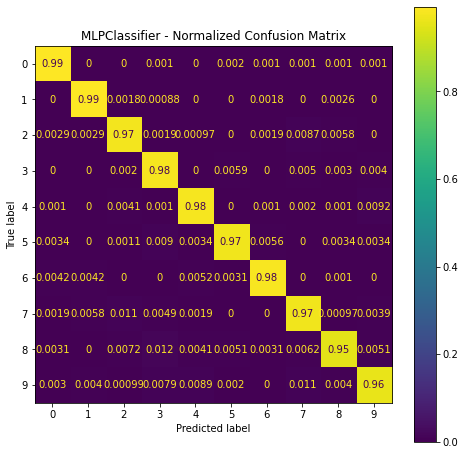

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.98       892
           6       0.99      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.98      0.95      0.96       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [69]:
# Evaluating Neural Network
y_pred = clf_neural_network.predict(X_test)

# Analyse metrics
analyse_metrics(model_name= 'MLPClassifier', 
                model=clf_neural_network,
                X_true=X_test,
                y_true=y_test, 
                y_pred=y_pred)

We can see that the Neural Network also performed very well on the test set.
As a final analysis, we will retrain the model with the whole training set (X_train), the union of X_train_set and X_val, and compare the results.

In [70]:
# Retraning MLPClassifier on the X_train
clf_neural_network = MLPClassifier(activation='relu',
                                   hidden_layer_sizes=(500,),
                                   random_state=42)
clf_neural_network.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(500,), random_state=42)

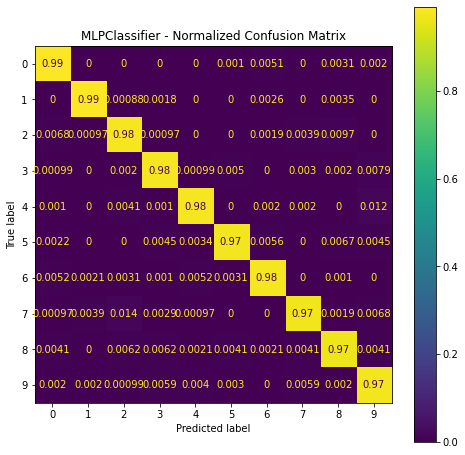

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.96      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [71]:
# Evaluating Neural Network
y_pred = clf_neural_network.predict(X_test)

# Analyse metrics
analyse_metrics(model_name= 'MLPClassifier', 
                model=clf_neural_network,
                X_true=X_test,
                y_true=y_test, 
                y_pred=y_pred)

We can see that it is very similar, so it didn't make much difference to retrain with the whole set.

# Final comments

In this section we will make an overview of the implemented experiments, results and relevant comments.